In [1]:
import os, random, importlib, time, copy
os.chdir('D:/L3/L3_SZ_CityScope/backend')
import geodata_toolbox
import proximity_indicator
import population_toolbox
import diversity_indicator
from geodata_toolbox import *
from proximity_indicator import ProximityIndicator
from population_toolbox import Population, Person
from diversity_indicator import DiversityIndicator
importlib.reload(geodata_toolbox)
importlib.reload(proximity_indicator)
importlib.reload(population_toolbox)
importlib.reload(diversity_indicator)


<module 'diversity_indicator' from 'D:\\L3\\L3_SZ_CityScope\\backend\\diversity_indicator.py'>

# Load Geodata

In [2]:
resolution = 11
POIs = PointGeoData(name='pois', 
                    src_geojson_path='0323/poi_outside_final.geojson')

POIs.make_h3_stats(resolution=resolution, agg_attrs={
    'usage': 'decompose'
})

Buildings = PolygonGeoData(name='buildings', 
                           src_geojson_path='0323/building_final.geojson')

Buildings.make_h3_stats(resolution, agg_attrs={
    'usage': 'decompose'
})

LU = PolygonGeoData(name='landuse', 
                    src_geojson_path='0323/land_final.geojson')
LU.make_h3_stats(resolution, agg_attrs={
    'usage': 'decompose'
})

# Load Population

In [3]:
Pop = Population('population', 'base_pop.geojson', None,
                 'shenzhen', proj_crs=4547, person_attrs=[])
Pop.set_base_sim_population(resolution)

# Initiate H3 Grids and Table Grids

In [4]:
H3 = H3Grids(resolution)
pop_stats = {k:{'tt_pop':v} for k,v in Pop.h3_count_sim_pop['home'][resolution].items()}
h3_stats = H3.combine_h3_stats([Buildings.h3_stats[resolution], 
                                POIs.h3_stats[resolution], 
                                LU.h3_stats[resolution],
                                pop_stats
                               ])
H3.set_current_h3_stats_as_base()

T = TableGrids('table', resolution, H3=H3,
               src_geojson_path='grid1_4326.geojson',
               table='shenzhen',
               proj_crs=4546)

# Update Layout and Generate Heatmap

In [5]:
# this funtion can generate a random layout string when noting is given False
def generate_random_layout(nothing=True):
    all_values = [-1,17,34,13,38,37,33,29,48,35,8,9,19,23]
    if nothing:
        all_values = [-1]
    data_list = np.random.choice(all_values, 276,True).tolist()
    data_list = [str(x) for x in data_list]
    data_str = 'i1 ' + ' '.join(data_list)
    return data_str

### Create a Proximity Indicator

In [6]:
P = ProximityIndicator(H3, T)
h3_features = H3.export_h3_features()

Connected to MQTT Broker!


### Update Layout, Do Calculation

In [7]:
new_layout_str = generate_random_layout(nothing=False)

t0 = time.time()
T.update(new_layout_str)
t1 = time.time()
print('Update layout costed {:4.4} seconds'.format(t1-t0))

t0 = time.time()
# rst = P.kde('proximity_park', '5500_area', minimum_ratio_th=0.25, 
#             bandwidth_multiplier=0.4)
rst = P.closeness('proximity_park', 5500, minimum_ratio_th=0.25, power=0.75)
t1 = time.time()
print('Heatmap calculation on H3 cells costed: {:4.4f}'.format(t1-t0))

t0 = time.time()
values = T.get_grid_value_from_h3_cells(resolution, 'proximity_park')
t1 = time.time()
print('Map H3 cell values to table cell values cost: {:4.4f}'.format(t1-t0))
park_location = [0 for i in range(len(T.features[4326]))]
for cell_id, cell_state in T.interactive_grid_layout['1'].items():
    if cell_state['code'] == 38:
        park_location[cell_id] = 1

Update layout costed 4.459 seconds
Heatmap calculation on H3 cells costed: 0.2235
Map H3 cell values to table cell values cost: 0.0000


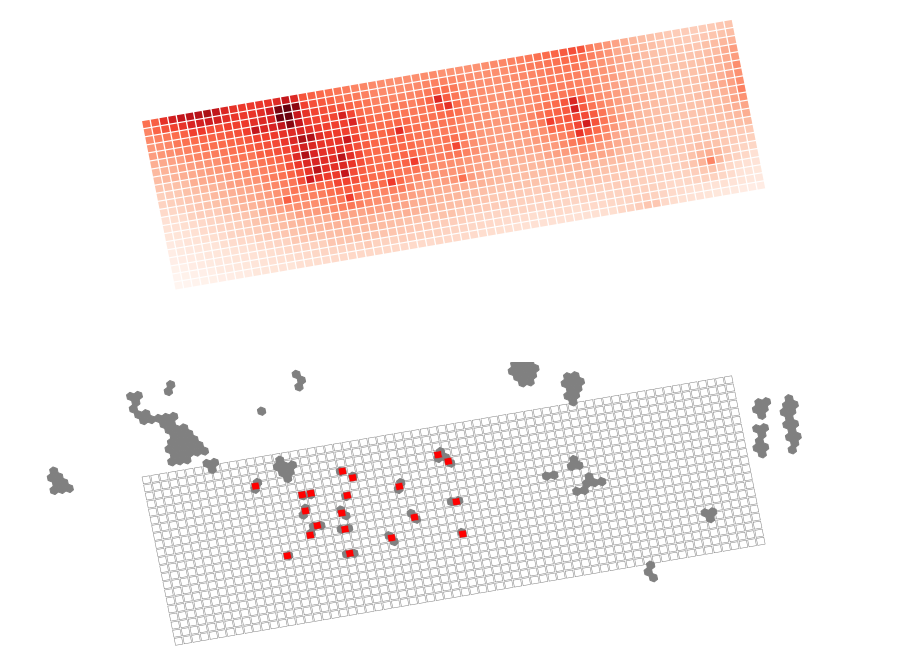

In [8]:
%matplotlib inline
fig = plt.figure(figsize=(16, 12))
P.verify_heatmap(T, name='proximity_park',
                 target_classes=5500,
                 minimum_ratio_th=0.25,
                 focus_table_grid_code=38)


## Calculate Proximity in Radar

In [9]:
park_proximity = P.return_accessibility_within_dist('park_proximity',
                                                    population_attr='tt_pop',
                                                    target_classes=5500,
                                                    kth=1,
                                                    dist_threshold=500/1.5)
print(f'park_proximity = {park_proximity}')

park_proximity = {'name': 'park_proximity', 'raw': 30962, 'normalized': 0.8910440888684241, 'to_frontend': 0.8910440888684241}


## Calculate Diversity in Radar

### Create a Diversity Indicator

In [10]:
D = DiversityIndicator(H3, T)

Connected to MQTT Broker!


In [11]:
new_layout_str = generate_random_layout(nothing=False)
T.update(new_layout_str)
diversity_third_places = D.return_lbcs_area_diversity('diversity_third_places', 
#                                                       target_lbcs_codes='third_places')
                                                      target_lbcs_codes=[2100,5500,4300])
print(diversity_third_places)

{'name': 'diversity_third_places', 'composition': {'2100': 1106238.8349250995, '5500': 291021.7682266031, '4300': 400922.920950833}, 'raw': 0.928216274124569, 'normalized': 0.8448988635015923, 'to_frontend': 0.8448988635015923}
